In [1]:
import xarray as xr
import cfgrib
import cartopy.crs as ccrs
from windspharm.xarray import VectorWind
from dask.distributed import Client, LocalCluster
#from xmovie import Movie
import matplotlib.pyplot as plt
import xrft
import numpy as np
import time

In [45]:
rootpath='/projekt2/hochatm/akuchar/SSW_2021/' # change to /gemeinsam_tmp/SSW_2021/
xr.set_options(keep_attrs=True)

In [3]:
client = Client(LocalCluster(host='192.168.154.3')) # 
client

/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40871 instead
  f"Port {expected} is already in use.\n"
distributed.diskutils - INFO - Found stale lock file and directory '/home/akuchar/notebooks/dask-worker-space/worker-4_eavnuv', purging


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://192.168.154.3:40871/status,
Dashboard: http://192.168.154.3:40871/status,Workers: 8
Total threads: 48,Total memory: 251.77 GiB
Status: running,Using processes: True
Comm: tcp://192.168.154.3:43497,Workers: 8
Dashboard: http://192.168.154.3:40871/status,Total threads: 48
Started: Just now,Total memory: 251.77 GiB
Comm: tcp://192.168.154.3:38161,Total threads: 6
Dashboard: http://192.168.154.3:45673/status,Memory: 31.47 GiB
Nanny: tcp://192.168.154.3:32869,


# ICON

In [8]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{rootpath}dwd/analysis_new/igar??????????'
ds = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={'filter_by_keys': filter_by_keys}
)
ds

,Array,Chunk
Bytes,8.99 GiB,99.01 MiB
Shape,"(93, 25, 721, 1440)","(1, 25, 721, 1440)"
Count,372 Tasks,93 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,8.99 GiB,99.01 MiB
Shape,"(93, 25, 721, 1440)","(1, 25, 721, 1440)"
Count,372 Tasks,93 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
ds_sel = ds[['u','w']]#.sel(isobaricInhPa=10)
u_fft = xrft.fft(ds_sel['u'], dim = 'longitude')#, real_dim = 'longitude')     
w_fft = xrft.fft(ds_sel['w'], dim = 'longitude')#, real_dim = 'longitude')    


/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [10]:
nl  = ds_sel.longitude.shape[0]**2
xyf = (u_fft*w_fft.conj()).real/nl
temp = xyf.sel(freq_longitude = slice(0,None))
zeros = xr.zeros_like(xyf)
zeros.loc[dict(freq_longitude=temp.freq_longitude.values[21:])] = 1
zeros.loc[dict(freq_longitude=-temp.freq_longitude.values[21:])] = 1

temp = xyf*zeros
temp_sum = temp.sum('freq_longitude')
temp_sum['isobaricInhPa'] = temp_sum.isobaricInhPa*100.
temp_sum

/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray (time: 93, isobaricInhPa: 25, latitude: 721)>
dask.array<sum-aggregate, shape=(93, 25, 721), dtype=float64, chunksize=(1, 25, 721), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 ... 2021-01-07
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+05 9.5e+04 ... 200.0 100.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
    valid_time     (time) datetime64[ns] 2020-12-15 ... 2021-01-07

In [30]:
# convert hPa to Pa and then derivate
scaling = 24*2600
vmfc = (-temp_sum.differentiate('isobaricInhPa')*scaling)#.load()
vmfc['isobaricInhPa'] = vmfc.isobaricInhPa/100.
vmfc['isobaricInhPa'].attrs['units'] = 'hPa'
vmfc['isobaricInhPa'].attrs['long_name'] = 'pressure'
vmfc.attrs['units'] = 'm/s/day'
vmfc.attrs['long_name'] = 'vertical momentum flux convergence'
vmfc.attrs['description'] = 'see https://doi.org/10.1029/2021GL092762'
t = time.localtime()
current_time = time.strftime("%Y%m%d %H:%M:%S", t)
vmfc.attrs['history'] = f'Published {current_time}'
vmfc.name = 'vmfc'
time_index = vmfc.time.to_index().strftime("%Y%m%d")
time_start = time_index[0]
time_end = time_index[-1]
outfile = infiles = f'{rootpath}dwd/analysis_new/vmfc_{time_start}_{time_end}.nc'
print(outfile)
vmfc.reset_coords(drop = True).to_netcdf(outfile)
"""vmfc.squeeze().plot.contourf(
    yincrease = False, 
    levels = 21,
    robust = True
)
plt.yscale('log')"""

/projekt2/hochatm/akuchar/SSW_2021/dwd/analysis_new/vmfc_20201215_20210107.nc


"vmfc.squeeze().plot.contourf(\n    yincrease = False, \n    levels = 21,\n    robust = True\n)\nplt.yscale('log')"

## Visualization

In [53]:
outfile = '/projekt2/hochatm/akuchar/SSW_2021/dwd/analysis_new/vmfc_20201215_20210107.nc'
ds_vmfc = xr.open_dataset(outfile)
ds_vmfc

<xarray.Dataset>
Dimensions:        (time: 93, isobaricInhPa: 25, latitude: 721)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 ... 2021-01-07
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 ...

In [54]:
ds_vmfc_daily = ds_vmfc.resample(time = '1D').mean()
ds_vmfc_daily

<xarray.Dataset>
Dimensions:        (time: 24, isobaricInhPa: 25, latitude: 721)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 2020-12-16 ... 2021-01-07
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 -1.049e-22 ... 4.5...

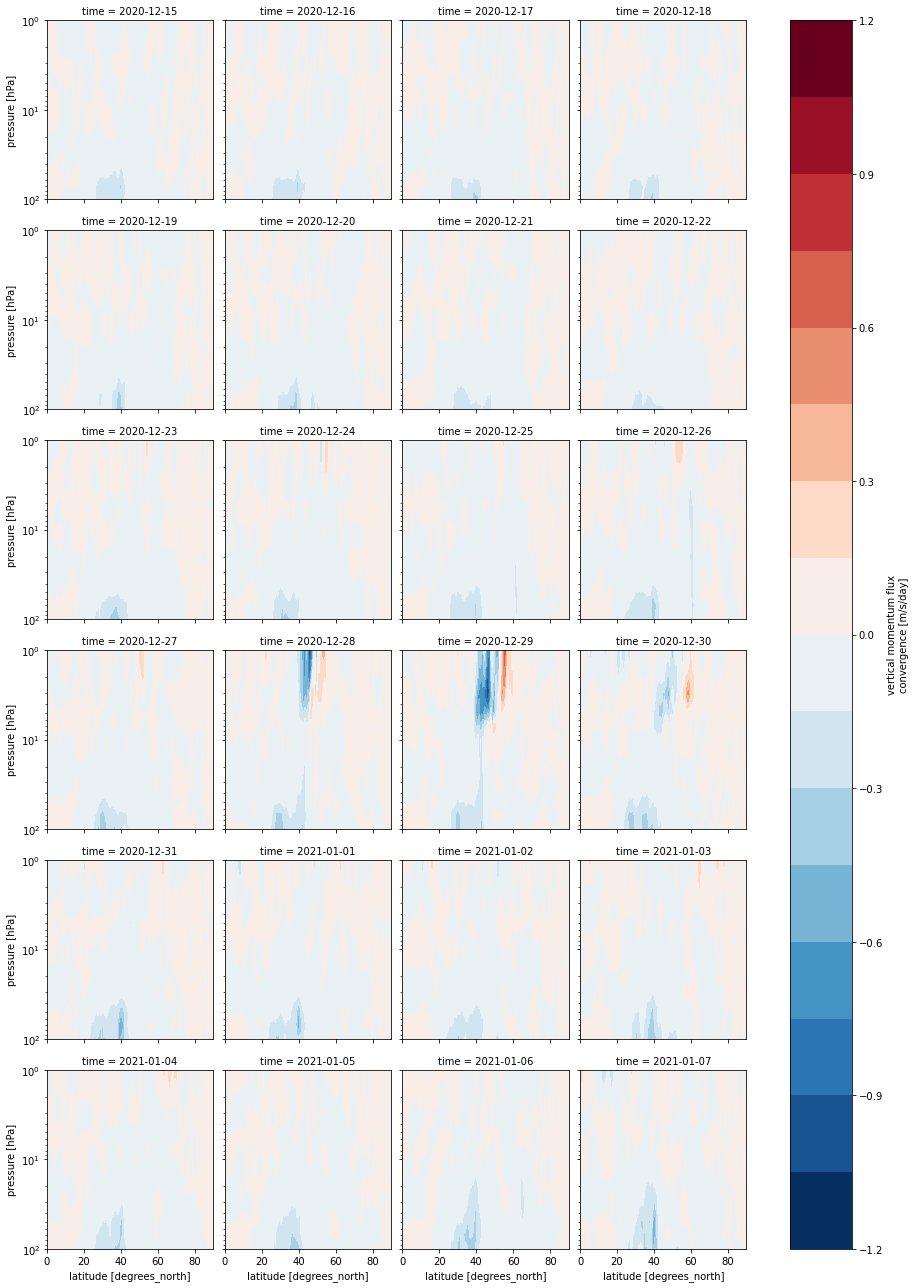

In [55]:
ds_vmfc_daily['vmfc'].sel(
    isobaricInhPa=slice(100,1),
    latitude = slice(0,None)
).squeeze().plot.contourf(
    yincrease = False, 
    levels = 21,
    col = 'time',
    col_wrap = 4,
)
plt.yscale('log')

# ERA5

In [4]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{rootpath}ERA5/ERA5_subset_202*.grib'
ds = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    chunks = {'time': 1}
    #backend_kwargs={'filter_by_keys': filter_by_keys}
)
ds

<xarray.Dataset>
Dimensions:        (time: 248, isobaricInhPa: 24, latitude: 721, longitude: 1440)
Coordinates:
    number         int64 0
  * time           (time) datetime64[ns] 2020-12-01 ... 2021-01-31T18:00:00
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    t              (time, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(1, 24, 721, 1440), meta=np.ndarray>
    u              (time, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(1, 24, 721, 1440), meta=np.ndarray>
    v              (time, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(1, 24, 721, 1440), meta=np.ndarray>
    w              (time, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(1, 24, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-14T15:31 GRIB to CDM+CF via cfgrib-0.9.9...

In [5]:
ds_sel = ds[['u','w']]#.sel(isobaricInhPa=10)
u_fft = xrft.fft(ds_sel['u'], dim = 'longitude')#, real_dim = 'longitude')     
w_fft = xrft.fft(ds_sel['w'], dim = 'longitude')#, real_dim = 'longitude')    


/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [6]:
nl  = ds_sel.longitude.shape[0]**2
xyf = (u_fft*w_fft.conj()).real/nl
temp = xyf.sel(freq_longitude = slice(0,None))
zeros = xr.zeros_like(xyf)
zeros.loc[dict(freq_longitude=temp.freq_longitude.values[21:])] = 1
zeros.loc[dict(freq_longitude=-temp.freq_longitude.values[21:])] = 1

temp = xyf*zeros
temp_sum = temp.sum('freq_longitude')
temp_sum['isobaricInhPa'] = temp_sum.isobaricInhPa*100.
temp_sum

/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray (time: 248, isobaricInhPa: 24, latitude: 721)>
dask.array<sum-aggregate, shape=(248, 24, 721), dtype=float64, chunksize=(1, 24, 721), chunktype=numpy.ndarray>
Coordinates:
    number         int64 0
  * time           (time) datetime64[ns] 2020-12-01 ... 2021-01-31T18:00:00
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+05 9.5e+04 ... 200.0 100.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
    valid_time     (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>

In [7]:
# convert hPa to Pa and then derivate
scaling = 24*2600
vmfc = (-temp_sum.differentiate('isobaricInhPa')*scaling)#.load()
vmfc['isobaricInhPa'] = vmfc.isobaricInhPa/100.
vmfc['isobaricInhPa'].attrs['units'] = 'hPa'
vmfc['isobaricInhPa'].attrs['long_name'] = 'pressure'
vmfc.attrs['units'] = 'm/s/day'
vmfc.attrs['long_name'] = 'vertical momentum flux convergence'
vmfc.attrs['description'] = 'see https://doi.org/10.1029/2021GL092762'
t = time.localtime()
current_time = time.strftime("%Y%m%d %H:%M:%S", t)
vmfc.attrs['history'] = f'Published {current_time}'
vmfc.name = 'vmfc'
time_index = vmfc.time.to_index().strftime("%Y%m%d")
time_start = time_index[0]
time_end = time_index[-1]
outfile = infiles = f'{rootpath}ERA5/vmfc_{time_start}_{time_end}.nc'
print(outfile)
vmfc.reset_coords(drop = True).to_netcdf(outfile)
"""vmfc.squeeze().plot.contourf(
    yincrease = False, 
    levels = 21,
    robust = True
)
plt.yscale('log')"""

/projekt2/hochatm/akuchar/SSW_2021/ERA5/vmfc_20201201_20210131.nc


"vmfc.squeeze().plot.contourf(\n    yincrease = False, \n    levels = 21,\n    robust = True\n)\nplt.yscale('log')"

## Visualization

In [58]:
outfile = f'/projekt2/hochatm/akuchar/SSW_2021/ERA5/vmfc_20201201_20210131.nc'
ds_vmfc = xr.open_dataset(outfile)
ds_vmfc

<xarray.Dataset>
Dimensions:        (time: 248, isobaricInhPa: 24, latitude: 721)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-01 ... 2021-01-31T18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 ...

In [59]:
ds_vmfc_daily = ds_vmfc.resample(time = '1D').mean()
ds_vmfc_daily

<xarray.Dataset>
Dimensions:        (time: 62, isobaricInhPa: 24, latitude: 721)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-01 2020-12-02 ... 2021-01-31
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 -4.636e-39 ... 5.6...

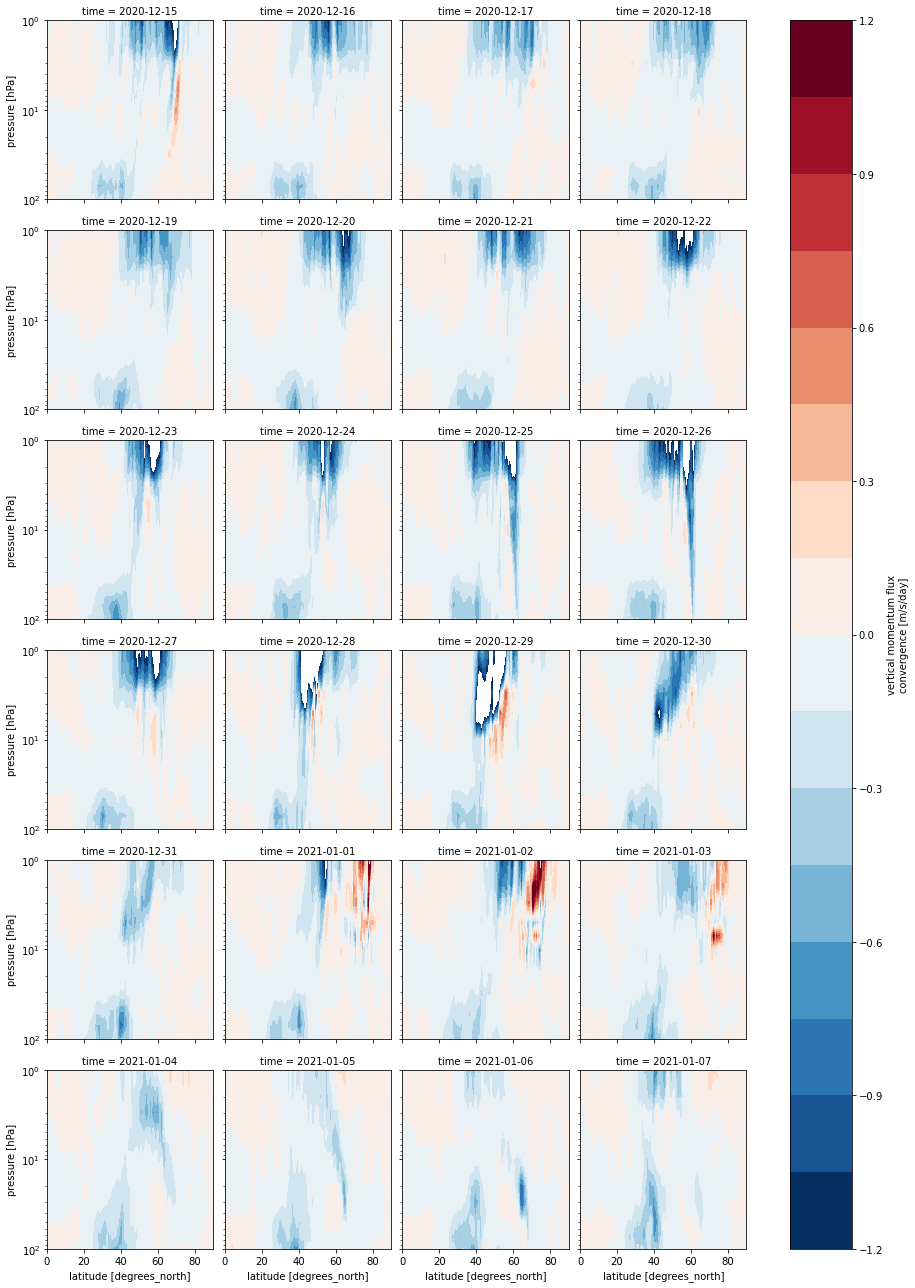

In [60]:
ds_vmfc_daily['vmfc'].sel(
    isobaricInhPa=slice(100,1),
    latitude = slice(None,0),
    time = slice('2020-12-15','2021-01-07')
).squeeze().plot.contourf(
    yincrease = False, 
    levels = np.linspace(-1.2,1.2,17),
    col = 'time',
    col_wrap = 4,
    extend = 'neither',
    cmap = 'RdBu_r'
)
plt.yscale('log')

# GEOS

In [36]:
infiles = f'{rootpath}geos-fp/geos5_subset*.nc'
ds = xr.open_mfdataset(
    infiles,
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    #chunks = {'time': 1}
)
ds = ds.rename(
    {'omega': 'w', 
     'lat': 'latitude',
     'lon': 'longitude',
     'lev': 'isobaricInhPa'
    }
)
ds

,Array,Chunk
Bytes,6.68 GiB,114.06 MiB
Shape,"(60, 36, 721, 1152)","(1, 36, 721, 1152)"
Count,240 Tasks,60 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,6.68 GiB,114.06 MiB
Shape,"(60, 36, 721, 1152)","(1, 36, 721, 1152)"
Count,240 Tasks,60 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [37]:
ds_sel = ds[['u','w']]#.sel(isobaricInhPa=10)
u_fft = xrft.fft(ds_sel['u'], dim = 'longitude')#, real_dim = 'longitude')     
w_fft = xrft.fft(ds_sel['w'], dim = 'longitude')#, real_dim = 'longitude')    


/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [38]:
nl  = ds_sel.longitude.shape[0]**2
xyf = (u_fft*w_fft.conj()).real/nl
temp = xyf.sel(freq_longitude = slice(0,None))
zeros = xr.zeros_like(xyf)
zeros.loc[dict(freq_longitude=temp.freq_longitude.values[21:])] = 1
zeros.loc[dict(freq_longitude=-temp.freq_longitude.values[21:])] = 1

temp = xyf*zeros
temp_sum = temp.sum('freq_longitude')
temp_sum['isobaricInhPa'] = temp_sum.isobaricInhPa*100.
temp_sum

/projekt2/hochatm/akuchar/.conda/envs/myenv/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray (time: 60, isobaricInhPa: 36, latitude: 721)>
dask.array<sum-aggregate, shape=(60, 36, 721), dtype=float64, chunksize=(1, 36, 721), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 ... 2020-12-29T18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+05 9.75e+04 ... 200.0 100.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0

In [39]:
# convert hPa to Pa and then derivate
scaling = 24*2600
vmfc = (-temp_sum.differentiate('isobaricInhPa')*scaling)#.load()
vmfc['isobaricInhPa'] = vmfc.isobaricInhPa/100.
vmfc['isobaricInhPa'].attrs['units'] = 'hPa'
vmfc['isobaricInhPa'].attrs['long_name'] = 'pressure'
vmfc.attrs['units'] = 'm/s/day'
vmfc.attrs['long_name'] = 'vertical momentum flux convergence'
vmfc.attrs['description'] = 'see https://doi.org/10.1029/2021GL092762'
t = time.localtime()
current_time = time.strftime("%Y%m%d %H:%M:%S", t)
vmfc.attrs['history'] = f'Published {current_time}'
vmfc.name = 'vmfc'
time_index = vmfc.time.to_index().strftime("%Y%m%d")
time_start = time_index[0]
time_end = time_index[-1]
outfile = infiles = f'{rootpath}geos-fp/vmfc_{time_start}_{time_end}.nc'
print(outfile)
vmfc.reset_coords(drop = True).to_netcdf(outfile)
"""vmfc.squeeze().plot.contourf(
    yincrease = False, 
    levels = 21,
    robust = True
)
plt.yscale('log')"""

/projekt2/hochatm/akuchar/SSW_2021/geos-fp/vmfc_20201215_20201229.nc


"vmfc.squeeze().plot.contourf(\n    yincrease = False, \n    levels = 21,\n    robust = True\n)\nplt.yscale('log')"

## Visualization

In [46]:
ds_vmfc = xr.open_dataset(outfile)
ds_vmfc

<xarray.Dataset>
Dimensions:        (time: 60, isobaricInhPa: 36, latitude: 721)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 ... 2020-12-29T18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 ...

In [47]:
ds_vmfc_daily = ds_vmfc.resample(time = '1D').mean()
ds_vmfc_daily

<xarray.Dataset>
Dimensions:        (time: 15, isobaricInhPa: 36, latitude: 721)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 2020-12-16 ... 2020-12-29
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 0.0 0.0 ... 0.0

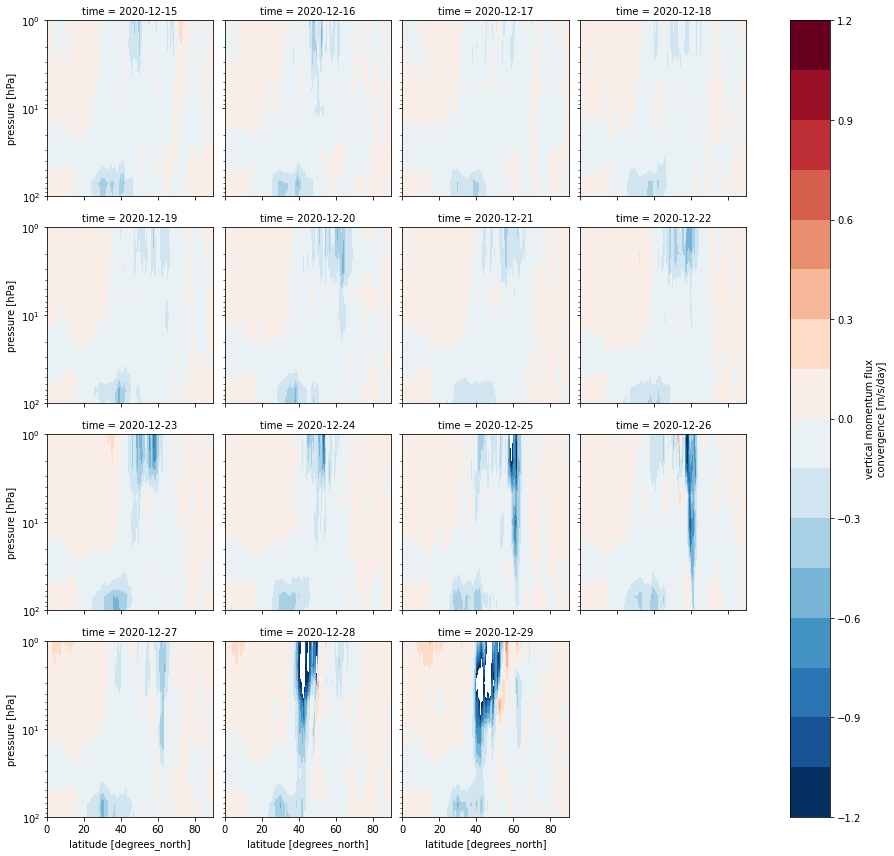

In [48]:
ds_vmfc_daily['vmfc'].sel(
    isobaricInhPa=slice(100,1),
    latitude = slice(0,None),
    time = slice('2020-12-15','2021-01-07')
).squeeze().plot.contourf(
    yincrease = False, 
    levels = np.linspace(-1.2,1.2,17),
    col = 'time',
    col_wrap = 4,
    extend = 'neither',
    cmap = 'RdBu_r'
)
plt.yscale('log')